# Predição de séries temporais da COVID-19
### Mortes

Autor: Saulo Leite

Dissertação: PREDIÇÃO DE SÉRIES TEMPORAIS DA COVID-19: UMA AVALIAÇÃO DE REDES NEURAIS COM ARIMA, LSTM, MLP & ES

### Importando bibliotecas
Para a implementação desse trabalho, foram necessárias muitas bibliotecas.

In [40]:
import math
import os
import datetime
import pandas
from pandas import read_csv
from pandas import Series
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
import numpy

import keras
import tensorflow.keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Tratamento de dados

Os dados usados neste trabalho são disponibilizados pela Universidade Johns Hopkins

In [41]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
urlretrieve(url, 'datasets/mortes_covid19.csv')
df_covid = pandas.read_csv('datasets/mortes_covid19.csv')
df_covid.drop(['Lat', 'Long'], axis=1, inplace=True)
df_country = df_covid.groupby('Country/Region').sum()
df_country.loc[['Brazil', 'India', 'US', 'Italy']]
s_brazil = df_country.loc['Brazil']
s_india = df_country.loc['India']
s_us = df_country.loc['US']
s_italy = df_country.loc['Italy']

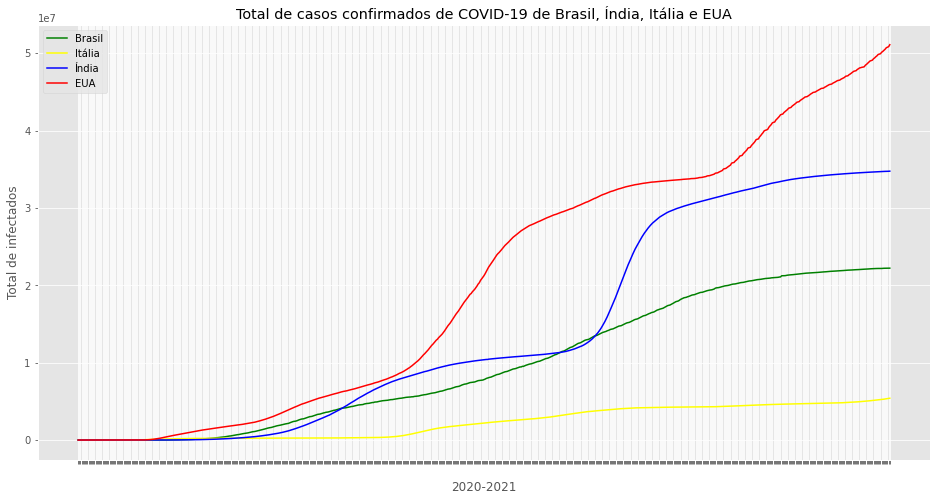

In [42]:
#Visualizando dados completos
plt.figure(figsize=(16,8))
plt.xticks(color='w')
plt.plot(s_brazil.index, s_brazil.values, label = 'Brasil', color = 'green')
plt.plot(s_us.index, s_italy.values, label = 'Itália', color = 'yellow')
plt.plot(s_india.index, s_india.values, label = 'Índia', color = 'blue')
plt.plot(s_us.index, s_us.values, label = 'EUA', color = 'red')
plt.title('Total de mortes por COVID-19 de Brasil, Índia, Itália e EUA')
plt.xlabel("2020-2021")
plt.ylabel("Total de mortes")
plt.legend()
plt.show()

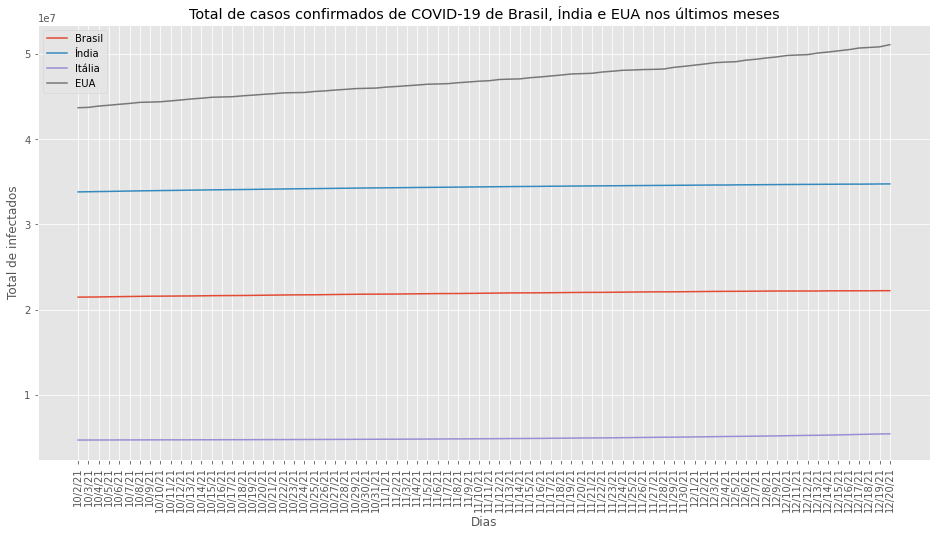

In [43]:
#Visualizando os dados em parte
tam = len(s_brazil)
plt.figure(figsize=(16,8))
plt.xticks(rotation = 90)
plt.plot(s_brazil.index[tam-80:tam], s_brazil.values[tam-80:tam], label = 'Brasil')
plt.plot(s_india.index[tam-80:tam], s_india.values[tam-80:tam], label = 'Índia')
plt.plot(s_italy.index[tam-80:tam], s_italy.values[tam-80:tam], label = 'Itália')
plt.plot(s_us.index[tam-80:tam], s_us.values[tam-80:tam], label = 'EUA')
plt.title('Total de mortes por COVID-19 de Brasil, Índia e EUA nos últimos meses')
plt.xlabel("Dias")
plt.ylabel("Total de mortes")
plt.legend()
plt.show()

In [44]:
#Exportação de dados totais
#Contabilizar os dias que estão com "zero casos"
#Estudar caso de inputação baysiana
s_brazil = s_brazil[s_brazil > 0]
s_india = s_india[s_india > 0]
s_italy = s_italy[s_italy > 0]
s_us = s_us[s_us > 0]
s_brazil.to_csv('datasets/countries/mortes_covid19_brazil.csv')
s_india.to_csv('datasets/countries/mortes_covid19_india.csv')
s_italy.to_csv('datasets/countries/mortes_covid19_italy.csv')
s_us.to_csv('datasets/countries/mortes_covid19_us.csv')

# Implementação dos modelos LSTM e MLP



In [ ]:
# converter uma matriz de valores em uma matriz de conjunto de dados
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [45]:
country = ['Brasil', 'Índia', 'Itália', 'EUA'] #Lista de países

#Grid Search
T_A = [0.01, 0.05, 0.1, 0.2] #0.01, 0.02, 0,03, 0.06, 0.1, 0.2; 
DROP = [0.01, 0.05, 0.1, 0.2]   #0.05, 0.1, 0.15, 0.2, 0.3, 0.5;
N_C = [200, 300, 400, 600]    #50, 100, 200, 300, 400, 600;
NPC = [8, 16, 32, 64] #Neurônios por camada

#Dicionários LSMT
dts = {} #Dicionário de datasets 
trpp = {} #Dicionário de treinos
tspp = {} #Dicionário de testes
trs = {} #Dicionário de scores de treinos 
tss = {} #Dicionário de scores de testes
tsm = {} #Dicionário de MAES

#Valores selecionados (Melhores valores)
strpp = {} #Dicionário de treinos
stspp = {} #Dicionário de testes
strs = {} #Dicionário de scores de treinos 
stss = {'Brasil':(9**15), 'Índia':(9**15), 'EUA':(9**15),'Itália':(9**15)} #Dicionário de scores de testes
stsm = {'Brasil':(9**15), 'Índia':(9**15), 'EUA':(9**15),'Itália':(9**15)} #Dicionário de MAE's Saída

#Dicionários MLP
dtsMLP = {} #Dicionário de datasets 
trppMLP = {} #Dicionário de treinos
tsppMLP = {} #Dicionário de testes
trsMLP = {} #Dicionário de scores de treinos 
tssMLP = {} #Dicionário de scores de testes
t_aMLP = {} #Dicionário de taxa de aprendizagem
tsmMLP = {} #Dicionário de MAES

#Valores selecionados (Melhores valores)
strppMLP = {} #Dicionário de treinos
stsppMLP = {} #Dicionário de testes
strsMLP = {} #Dicionário de scores de treinos 
stssMLP = {'Brasil':(9**15), 'Índia':(9**15), 'EUA':(9**15),'Itália':(9**15)} #Dicionário de scores de testes
stsmMLP = {'Brasil':(9**15), 'Índia':(9**15), 'EUA':(9**15),'Itália':(9**15)} #Dicionário de MAE's Saída

st_aMLP = {} #Dicionário de taxa de aprendizagem saída

#Ajustes para seleção LSTM
t_a = {} #Dicionário de taxa de aprendizagem
dropout = {} #Dicionário de dropout
n_cel = {} #Dicionário de número de células
st_a = {} #Dicionário de taxa de aprendizagem saída
sdropout = {} #Dicionário de dropout saída
sn_cel = {} #Dicionário de número de células saída

#Ajustes para seleção MLP
t_a = {} #Dicionário de taxa de aprendizagem
dropoutMLP = {} #Dicionário de dropout
n_neu = {} #Dicionário de número de neurônios
st_aMLP = {} #Dicionário de taxa de aprendizagem saída
sdropoutMLP = {} #Dicionário de dropout saída
sn_neu = {} #Dicionário de número de neurônios

for i in range(len(country)):
    for z in range(len(T_A)):
        for j in range(len(DROP)):
            for k in range(len(N_C)):
                if country[i] == 'Brasil':
                    dataframe = read_csv('datasets/countries/mortes_covid19_brazil.csv', usecols=[1], engine='python')
                    dataset = dataframe.values
                    dataset = dataset.astype('float32')
                if country[i] == 'Índia':
                    dataframe = read_csv('datasets/countries/mortes_covid19_india.csv', usecols=[1], engine='python')
                    dataset = dataframe.values
                    dataset = dataset.astype('float32')
                if country[i] == 'Itália':
                    dataframe = read_csv('datasets/countries/mortes_covid19_italy.csv', usecols=[1], engine='python')
                    dataset = dataframe.values
                    dataset = dataset.astype('float32')
                if country[i] == 'EUA':
                    dataframe = read_csv('datasets/countries/mortes_covid19_us.csv', usecols=[1], engine='python')
                    dataset = dataframe.values
                    dataset = dataset.astype('float32')
                
                #LSTM
                
                # Normalizar o dataset
                scaler = MinMaxScaler(feature_range=(0, 1))
                dataset = scaler.fit_transform(dataset)
                # dividir em conjuntos de treinamento e teste
                train_size = int(len(dataset) * 0.67)
                test_size = len(dataset) - train_size
                train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
                # remodelar em X = t e Y = t + 1
                look_back = 1
                trainX, trainY = create_dataset(train, look_back)
                testX, testY = create_dataset(test, look_back)
                # remodelar a entrada para ser [amostras, intervalos de tempo, recursos]
                trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
                testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
                #Criando modelo
                model = Sequential()
                keras.backend.set_epsilon(1)
                #Adicionando camada LSTM e alguma regularização de Dropout 
                model.add(LSTM(units=int(N_C[k])))
                model.add(Dropout(float(DROP[j])))
                model.add(Dense(units=1, activation='linear'))
                #definindo hiper parâmetros
                adam = keras.optimizers.Adam(learning_rate=float(T_A[z]), beta_1=0.999, beta_2=0.999, amsgrad=False)
                model.compile(loss='mean_squared_error', optimizer='adam')
                model.fit(trainX, trainY, epochs=200, batch_size=40) #Mudar para 300 épocas - fora do grid search
                #fazer previsões
                trainPredict = model.predict(trainX)
                testPredict = model.predict(testX)
                # inverter previsões
                trainPredict = scaler.inverse_transform(trainPredict)
                trainY = scaler.inverse_transform([trainY])
                testPredict = scaler.inverse_transform(testPredict)
                testY = scaler.inverse_transform([testY])
                # calcular raiz quadrada média do erro
                trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
                print('Train Score: %.2f RMSE' % (trainScore))
                testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
                print('Test Score: %.2f RMSE' % (testScore))
                #Calcular o MAE:
                MAE = mean_absolute_error(testY[0], testPredict[:,0])
                # mudar para treinar previsões para traçar
                trainPredictPlot = numpy.empty_like(dataset)
                trainPredictPlot[:, :] = numpy.nan
                trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
                # previsões de teste de deslocamento para plotagem
                testPredictPlot = numpy.empty_like(dataset)
                testPredictPlot[:, :] = numpy.nan
                testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
                
                #MLP
                train_size = int(len(dataset) * 0.67)
                test_size = len(dataset) - train_size
                train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
                # remodelar em X = t e Y = t + 1
                look_back = 1
                trainX, trainY = create_dataset(train, look_back)
                testX, testY = create_dataset(test, look_back)
                # remodelar a entrada para ser [amostras, intervalos de tempo, recursos]
                trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
                testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
                model = Sequential()
                model.add(Dense(NPC[i], activation='sigmoid', input_dim = 1))
                model.add(Dropout(float(DROP[j])))
                model.add(Dense(NPC[i], activation='tanh'))
                model.add(Dropout(float(DROP[j])))
                model.add(Dense(NPC[i], activation='relu'))
                model.add(Dropout(float(DROP[j])))
                model.add(Dense(1))
                adam = keras.optimizers.Adam(learning_rate=float(T_A[z]))
                model.compile(optimizer=adam , loss='mean_squared_error')
                model.fit(trainX, trainY, epochs=200, batch_size = 40)
                #fazer previsões
                trainPredictMLP = model.predict(trainX)
                testPredictMLP = model.predict(testX)
                # inverter previsões
                trainPredictMLP = scaler.inverse_transform(trainPredictMLP)
                trainY = scaler.inverse_transform([trainY])
                testPredictMLP = scaler.inverse_transform(testPredictMLP)
                testY = scaler.inverse_transform([testY])
                # calcular raiz quadrada média do erro
                trainScoreMLP = math.sqrt(mean_squared_error(trainY[0], trainPredictMLP[:,0]))
                print('Train Score MLP: %.2f RMSE' % (trainScoreMLP))
                testScoreMLP = math.sqrt(mean_squared_error(testY[0], testPredictMLP[:,0]))
                print('Test Score MLP: %.2f RMSE' % (testScoreMLP))
                #Calcular o MAE:
                MAEMLP = mean_absolute_error(testY[0], testPredictMLP[:,0])
                # mudar para treinar previsões para traçar
                trainPredictPlotMLP = numpy.empty_like(dataset)
                trainPredictPlotMLP[:, :] = numpy.nan
                trainPredictPlotMLP[look_back:len(trainPredict)+look_back, :] = trainPredict
                # previsões de teste de deslocamento para plotagem
                testPredictPlotMLP = numpy.empty_like(dataset)
                testPredictPlotMLP[:, :] = numpy.nan
                testPredictPlotMLP[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


                #Armazenando as informações em dicionários LSTM
                tss[country[i]] = testScore
                tsm[country[i]] = MAE
                trpp[country[i]] = trainPredictPlot
                tspp[country[i]] = testPredictPlot
                trs[country[i]] = trainScore
                dts[country[i]] = scaler.inverse_transform(dataset)
                t_a[country[i]] = T_A[z]
                dropout[country[i]] = DROP[j]
                n_cel[country[i]] = N_C[k]
                tsm[country[i]] = MAE
                if tss[country[i]] < stss[country[i]]: #Condição de verificação dos melhores resultados
                    strpp[country[i]] = trainPredictPlot
                    stspp[country[i]] = testPredictPlot
                    strs[country[i]] = trainScore
                    stss[country[i]] = testScore
                    st_a[country[i]] = T_A[z]
                    sdropout[country[i]] = DROP[j]
                    sn_cel[country[i]] = N_C[k]
                    stsm[country[i]] = MAE
                    
                #Armazenando as informações em dicionários MLP
                tssMLP[country[i]] = testScoreMLP
                trppMLP[country[i]] = trainPredictPlotMLP
                tsppMLP[country[i]] = testPredictPlotMLP
                trsMLP[country[i]] = trainScoreMLP
                t_aMLP[country[i]] = T_A[z]
                dropoutMLP[country[i]] = DROP[j]
                n_neu[country[i]] = NPC[i]
                tsmMLP[country[i]] = MAEMLP
                
                if tssMLP[country[i]] < stssMLP[country[i]]: #Condição de verificação dos melhores resultados
                    strppMLP[country[i]] = trainPredictPlotMLP
                    stsppMLP[country[i]] = testPredictPlotMLP
                    strsMLP[country[i]] = trainScoreMLP
                    stssMLP[country[i]] = testScoreMLP
                    st_aMLP[country[i]] = T_A[z]
                    sdropoutMLP[country[i]] = DROP[j]
                    sn_neu[country[i]] = NPC[i]
                    stsmMLP[country[i]] = MAEMLP

NameError: name 'create_dataset' is not defined

In [ ]:
#Plotar gráficos com base nas previsões do modelo LSTM
for i in range(len(country)): #loop de repatição apra mostrar todos os países
    
    print('\n LSTM - O melhor caso - %s \n' %(country[i]))
    plt.figure(figsize=(10,5))
    plt.title('Predição de casos confirmados de COVID19 (%s) com LSTM' %(country[i]))
    plt.ylabel('Casos confirmados')
    plt.xlabel('Quantidade de dias')
    plt.plot(dts[country[i]], label = 'Dados reais')
    plt.plot(strpp[country[i]], label = 'Predição de treino')
    plt.plot(stspp[country[i]], label = 'Predição de teste')
    plt.legend()
    plt.show()
    print('Train Score: %.2f RMSE' % (strs[country[i]]))
    print('Test Score: %.2f RMSE' % (stss[country[i]]))
    print('MAE:', stsm[country[i]])
    print('Taxa de aprendizagem:', st_a[country[i]])
    print('Dropout:', sdropout[country[i]])
    print('Número de células:', sn_cel[country[i]])

    print('\n LSTM - O segundo melhor - %s \n' %(country[i]))
    plt.figure(figsize=(10,5))
    plt.title('Predição de casos confirmados de COVID19 (%s) com LSTM' %(country[i]))
    plt.ylabel('Casos confirmados')
    plt.xlabel('Quantidade de dias')
    plt.plot(dts[country[i]], label = 'Dados reais')
    plt.plot(trpp[country[i]], label = 'Predição de treino')
    plt.plot(tspp[country[i]], label = 'Predição de teste')
    plt.legend()
    plt.show()
    print('Train Score: %.2f RMSE' % (trs[country[i]]))
    print('Test Score: %.2f RMSE' % (tss[country[i]]))
    print('MAE:', tsm[country[i]])
    print('Taxa de aprendizagem:', t_a[country[i]])
    print('Dropout:', dropout[country[i]])
    print('Número de células:', n_cel[country[i]])
    print('\n\n')
    
    #Armazenando dados de treino e teste da predição
    if country[i] == 'Brasil':
        st = strpp[country[i]]
        ts = stspp[country[i]]
        numpy.savetxt('C:/Users/sjoel/PA/outputs/test/out_lstm_mortes_test_brazil.csv',st,delimiter=',')
        numpy.savetxt('C:/Users/sjoel/PA/outputs/train/out_lstm_mortes_train_brazil.csv',ts,delimiter=',')
    if country[i] == 'Índia':
        st = strpp[country[i]]
        ts = stspp[country[i]]
        numpy.savetxt('C:/Users/sjoel/PA/outputs/test/out_lstm_mortes_test_india.csv',st,delimiter=',')
        numpy.savetxt('C:/Users/sjoel/PA/outputs/train/out_lstm_mortes_train_india.csv',ts,delimiter=',')
    if country[i] == 'Itália':
        st = strpp[country[i]]
        ts = stspp[country[i]]
        numpy.savetxt('C:/Users/sjoel/PA/outputs/test/out_lstm_mortes_test_italia.csv',st,delimiter=',')
        numpy.savetxt('C:/Users/sjoel/PA/outputs/train/out_lstm_mortes_train_italia.csv',ts,delimiter=',')
    if country[i] == 'EUA':
        st = strpp[country[i]]
        ts = stspp[country[i]]
        numpy.savetxt('C:/Users/sjoel/PA/outputs/test/out_lstm_mortes_test_eua.csv',st,delimiter=',')
        numpy.savetxt('C:/Users/sjoel/PA/outputs/train/out_lstm_mortes_train_eua.csv',ts,delimiter=',')

In [ ]:
#Plotar gráficos com base nas previsões do modelo MLP
for i in range(len(country)):
    print('\n MLP - O melhor caso - %s \n' %(country[i]))
    plt.figure(figsize=(10,5))
    plt.title('Predição de casos confirmados de COVID19 (%s) com MLP' %(country[i]))
    plt.ylabel('Casos confirmados')
    plt.xlabel('Quantidade de dias')
    plt.plot(dts[country[i]], label = 'Dados reais')
    plt.plot(strppMLP[country[i]], label = 'Predição de treino')
    plt.plot(stsppMLP[country[i]], label = 'Predição de teste')
    plt.legend()
    plt.show()
    print('Train Score: %.2f RMSE' % (strsMLP[country[i]]))
    print('Test Score: %.2f RMSE' % (stssMLP[country[i]]))
    print('Taxa de aprendizagem:', st_aMLP[country[i]])
    print('Dropout:', sdropoutMLP[country[i]])
    print('Número de células por camada:',sn_neu[country[i]])


    print('\n MLP- O segundo melhor - %s \n' %(country[i]))
    plt.figure(figsize=(10,5))
    plt.title('Predição de casos confirmados de COVID19 (%s) com MLP' %(country[i]))
    plt.ylabel('Casos confirmados')
    plt.xlabel('Quantidade de dias')
    plt.plot(dts[country[i]], label = 'Dados reais')
    plt.plot(trppMLP[country[i]], label = 'Predição de treino')
    plt.plot(tsppMLP[country[i]], label = 'Predição de teste')
    plt.legend()
    plt.show()
    print('Train Score: %.2f RMSE' % (trsMLP[country[i]]))
    print('Test Score: %.2f RMSE' % (tssMLP[country[i]]))
    print('Taxa de aprendizagem:', t_aMLP[country[i]])
    print('Dropout:', dropoutMLP[country[i]])
    print('Número de células por camada:',n_neu[country[i]])
    print('\n\n')
        
    if country[i] == 'Brasil':
        st = strppMLP[country[i]]
        ts = stsppMLP[country[i]]
        numpy.savetxt('C:/Users/sjoel/PA/outputs/test/out_mlp_mortes_test_brazil.csv',st,delimiter=',')
        numpy.savetxt('C:/Users/sjoel/PA/outputs/train/out_mlp_mortes_train_brazil.csv',ts,delimiter=',')
    if country[i] == 'Índia':
        st = strppMLP[country[i]]
        ts = stsppMLP[country[i]]
        numpy.savetxt('C:/Users/sjoel/PA/outputs/test/out_mlp_mortes_test_india.csv',st,delimiter=',')
        numpy.savetxt('C:/Users/sjoel/PA/outputs/train/out_mlp_mortes_train_india.csv',ts,delimiter=',')
    if country[i] == 'Itália':
        st = strppMLP[country[i]]
        ts = stsppMLP[country[i]]
        numpy.savetxt('C:/Users/sjoel/PA/outputs/test/out_mlp_mortes_test_italia.csv',st,delimiter=',')
        numpy.savetxt('C:/Users/sjoel/PA/outputs/train/out_mlp_mortes_train_italia.csv',ts,delimiter=',')
    if country[i] == 'EUA':
        st = strppMLP[country[i]]
        ts = stsppMLP[country[i]]
        numpy.savetxt('C:/Users/sjoel/PA/outputs/test/out_mlp_mortes_test_eua.csv',st,delimiter=',')
        numpy.savetxt('C:/Users/sjoel/PA/outputs/train/out_mlp_mortes_train_eua.csv',ts,delimiter=',')

# Implementação do modelo Exponential Smoothing

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_

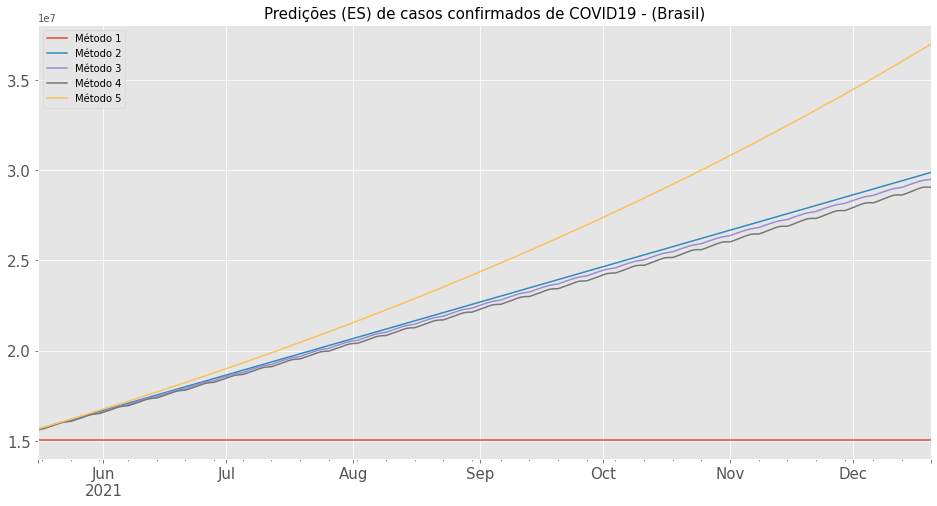

*************Métricas do Algoritmo de Suavização Simples*************
                                                                                                                                                                                                                                                              
Erro médio absoluto do Algoritmo de Suavização Simples : 5126008.223
Raiz do erro médio quadrado do Algoritmo de Suavização Simples : 5460880.11
                                                                                                                                                                                                                                                              
*************Métricas do Algoritmo de Suavização de Holt*************
                                                                                                                                                                                                             

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_

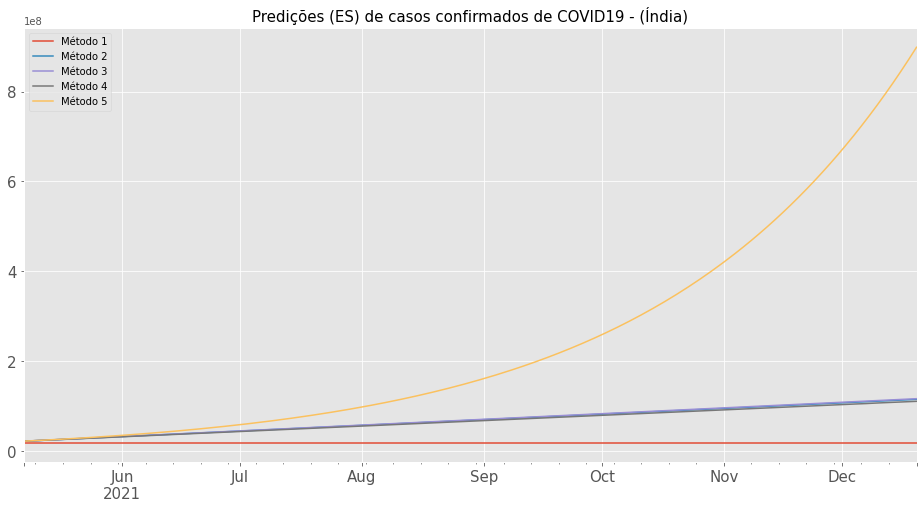

*************Métricas do Algoritmo de Suavização Simples*************
                                                                                                                                                                                                                                                              
Erro médio absoluto do Algoritmo de Suavização Simples : 13215705.866
Raiz do erro médio quadrado do Algoritmo de Suavização Simples : 13523790.071
                                                                                                                                                                                                                                                              
*************Métricas do Algoritmo de Suavização de Holt*************
                                                                                                                                                                                                          

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_

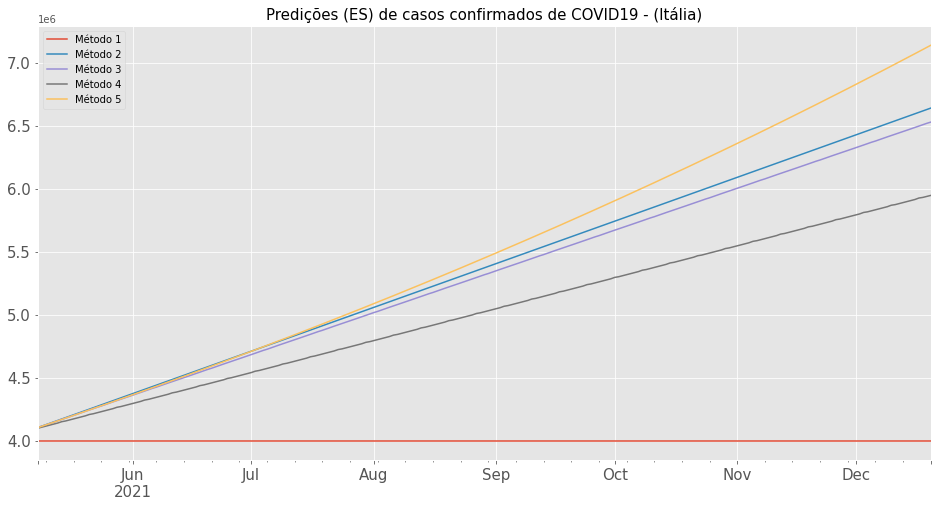

*************Métricas do Algoritmo de Suavização Simples*************
                                                                                                                                                                                                                                                              
Erro médio absoluto do Algoritmo de Suavização Simples : 553714.991
Raiz do erro médio quadrado do Algoritmo de Suavização Simples : 636222.201
                                                                                                                                                                                                                                                              
*************Métricas do Algoritmo de Suavização de Holt*************
                                                                                                                                                                                                              

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_

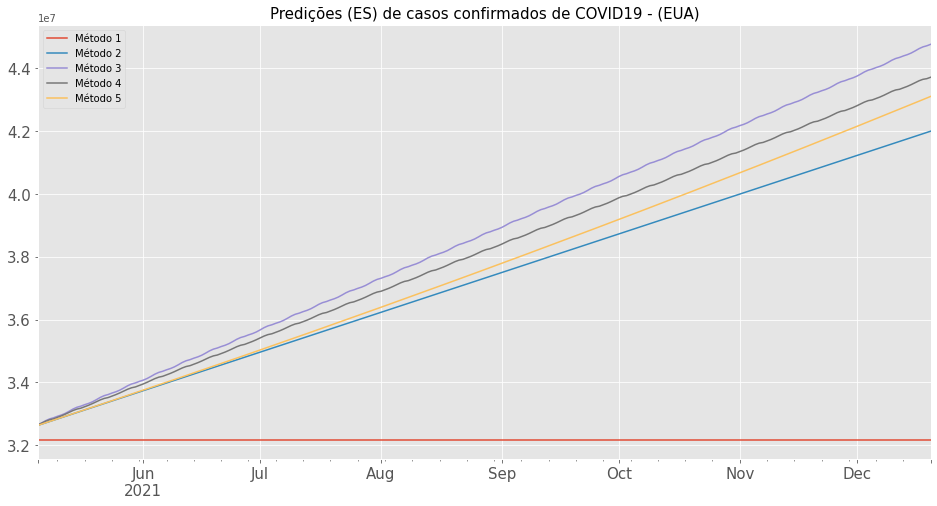

*************Métricas do Algoritmo de Suavização Simples*************
                                                                                                                                                                                                                                                              
Erro médio absoluto do Algoritmo de Suavização Simples : 7681286.135
Raiz do erro médio quadrado do Algoritmo de Suavização Simples : 9761313.101
                                                                                                                                                                                                                                                              
*************Métricas do Algoritmo de Suavização de Holt*************
                                                                                                                                                                                                            

In [ ]:
country = ['Brasil', 'Índia', 'Itália', 'EUA'] #Lista de países
for i in range(len(country)):
    if country[i] == "Brasil":
        dataframe = read_csv("datasets/countries/mortes_covid19_brazil_date.csv",encoding='utf-8',index_col='date')

    if country[i] == "Índia":
        dataframe = read_csv("datasets/countries/mortes_covid19_india_date.csv",encoding='utf-8',index_col='date')
        
    if country[i] == "Itália":
        dataframe = read_csv("datasets/countries/mortes_covid19_italy_date.csv",encoding='utf-8',index_col='date')

    if country[i] == "EUA":
        dataframe = read_csv("datasets/countries/mortes_covid19_us_date.csv",encoding='utf-8',index_col='date')
    total = len(dataframe)
    t = int(total*0.33)
    treino=dataframe.iloc[:-t]
    teste=dataframe.iloc[-t:]
    #Implementando modelos
    model1=SimpleExpSmoothing(treino).fit(smoothing_level=0.111,optimized=True)
    modelo1=model1.forecast(len(teste))
    model2=Holt(treino).fit(smoothing_level=0.7187)
    modelo2=model2.forecast(len(teste))
    model3=ExponentialSmoothing(treino,trend='add',seasonal='add').fit()
    modelo3=model3.forecast(len(teste))
    model4=ExponentialSmoothing(treino,trend='add',seasonal='mul').fit()
    modelo4=model4.forecast(len(teste))
    model5=ExponentialSmoothing(treino,trend='mul',seasonal='add').fit()
    modelo5=model5.forecast(len(teste))
    #plt.plot(teste)
    plt.figure(figsize=(16,8))
    modelo1.plot(figsize=(16,8))
    modelo2.plot()
    modelo3.plot()
    modelo4.plot()
    modelo5.plot()
    plt.title("Predições (ES) de casos confirmados de COVID19 - (%s)" %(country[i]), size=15)
    plt.xticks(size=15)
    plt.yticks(size=15)
    lista=['Método 1','Método 2','Método 3','Método 4','Método 5']
    plt.legend(lista)
    plt.show()
    print('*************Métricas do Algoritmo de Suavização Simples*************')
    print(' '*254)
    print('Erro médio absoluto do Algoritmo de Suavização Simples :',round(mean_absolute_error(teste,modelo1),3))
    print('Raiz do erro médio quadrado do Algoritmo de Suavização Simples :',round(mean_squared_error(teste,modelo1)**0.5,3))


    print(' '*254)
    print('*************Métricas do Algoritmo de Suavização de Holt*************')
    print(' '*254)
    print('Erro médio absoluto do Algoritmo de Suavização Holt:',round(mean_absolute_error(teste,modelo2),3))
    print('Raiz do erro médio quadrado do Algoritmo de Suavização',round(mean_squared_error(teste,modelo2)**0.5,3))

    print(' '*254)
    print('*************Métricas do Algoritmo de Suavização de Holt-Winters aditivo*************')
    print(' '*254)
    print('Erro médio absoluto do Algoritmo de Suavização Holt-Winters aditivo :', round(mean_absolute_error(teste,modelo3),3))
    print('Raiz do erro médio quadrado do Algoritmo de Suavização Holt-Winters aditivo :',round(mean_squared_error(teste,modelo3)**0.5,3))

    print(' '*254)
    print('*************Métricas do Algoritmo de Suavização de Holt-Winters multiplicativo*************')
    print(' '*254)
    print('Erro médio absoluto do Algoritmo de Suavização Holt-Winters multiplicativo :',round(mean_absolute_error(teste,modelo4),3))
    print('Raiz do erro médio quadrado do Algoritmo de Suavização Holt-Winters multiplicativo :',round(mean_squared_error(teste,modelo4)**0.5,3))

    print(' '*254)
    print('*************Métricas do Algoritmo de Suavização de Pegels aditivo *************')
    print(' '*254)
    print('Erro médio absoluto do Algoritmo de Suavização Pegels aditivo :',round(mean_absolute_error(teste,modelo5),3))
    print('Raiz do erro médio quadrado do Algoritmo de Suavização Pegels aditivo :',round(mean_squared_error(teste,modelo5)**0.5,3))

    print(' '*254)

# Modelo ARIMA

In [ ]:
#evaluate an ARIMA model using a walk-forward validation
p = [0,1]
d = [0,1]
q = [0,1]
sp = {}
sd = {}
sq = {}
pred = {}
out = {}
rmses = {}
maes = {}
rmsess = {'Brasil':(9**15), 'Índia':(9**15), 'EUA':(9**15),'Itália':(9**15)} #Dicionário de scores de testes
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
country = ['Brasil', 'Índia', 'Itália', 'EUA'] #Lista de países
# load dataset
for i in range(len(country)):
    for z in range(len(p)):
        for j in range(len(d)):
            for k in range(len(q)):
                if country[i] == 'Brasil':
                    series = read_csv('datasets/countries/mortes_covid19_brazil.csv', usecols=[1], engine='python')
                if country[i] == 'Índia':
                    series = read_csv('datasets/countries/mortes_covid19_india.csv', usecols=[1], engine='python')
                if country[i] == 'Itália':
                    series = read_csv('datasets/countries/mortes_covid19_italy.csv', usecols=[1], engine='python')
                if country[i] == 'EUA':
                    series = read_csv('datasets/countries/mortes_covid19_us.csv', usecols=[1], engine='python')
                # split into train and test sets
                X = series.values
                size = int(len(X) * 0.66)
                train, test = X[0:size], X[size:len(X)]
                history = [x for x in train]
                predictions = list()
                # walk-forward validation
                for t in range(len(test)):
                    model = ARIMA(history, order=(p[z],d[j],q[k]))
                    model_fit = model.fit()
                    output = model_fit.forecast()
                    yhat = output[0]
                    predictions.append(yhat)
                    obs = test[t]
                    history.append(obs)
                    #print('predicted=%f, expected=%f' % (yhat, obs))
                # evaluate forecasts
                mae = mean_absolute_error(test, predictions)
                rmse = sqrt(mean_squared_error(test, predictions))
                maes[country[i]] = mae
                rmses[country[i]] = rmse
                pred[country[i]] = predictions
                if rmses[country[i]] < rmsess[country[i]]:
                    out[country[i]] = test
                    sp[country[i]] = p[z]
                    sd[country[i]] = d[j]
                    sq[country[i]] = q[k]
                    rmses[country[i]] = rmse

In [ ]:
for i in range(len(country)):
    plt.figure(figsize=(10,5))
    plt.title('Predição de casos confirmados de COVID19 (%s) com ARIMA' %(country[i]))
    plt.ylabel('Casos confirmados')
    plt.xlabel('Quantidade de dias')
    plt.plot(out[country[i]], label = 'Dados reais')
    plt.plot(pred[country[i]], label = 'Predição', color='red')
    plt.legend()
    plt.show()
    print('Test RMSE: %.3f\n\n' % rmses[country[i]])
    print('Test MAE: %.3f\n\n' % maes[country[i]])
    print("p:", sp[country[i]],"d:",sd[country[i]],"q:",sq[country[i]])